In [2]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

In [3]:
# Define the date range
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# List of stock tickers to download
tickers = ['AMBUJACEM.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

# Download the data
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Reset index to bring 'Date' into the columns
data = data.reset_index()


In [4]:
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute','Ticker'])

#pivot the melted DataFrame to have the attributes (open,high,low..) as columns
data_pivoted = data_melted.pivot_table(index=['Date','Ticker'], columns='Attribute',values='value',aggfunc='first')

#Reset index to turn multiindex into cols
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date        Ticker    Adj Close        Close         High  \
0         2023-07-24  AMBUJACEM.NS   421.477600   422.750000   428.799988   
1         2023-07-24   HDFCBANK.NS  1655.789429  1678.400024  1684.650024   
2         2023-07-24       INFY.NS  1312.125488  1336.599976  1349.900024   
3         2023-07-24        TCS.NS  3338.298096  3394.750000  3413.449951   
4         2023-07-25  AMBUJACEM.NS   438.775391   440.100006   441.899994   

Attribute          Low         Open      Volume  
0           415.450012   417.000000   3203223.0  
1          1670.099976  1678.500000  16089722.0  
2          1334.250000  1341.000000   8859789.0  
3          3372.100098  3381.000000   1680132.0  
4           423.149994   423.149994   6432788.0  


Stock Market Performance over the years

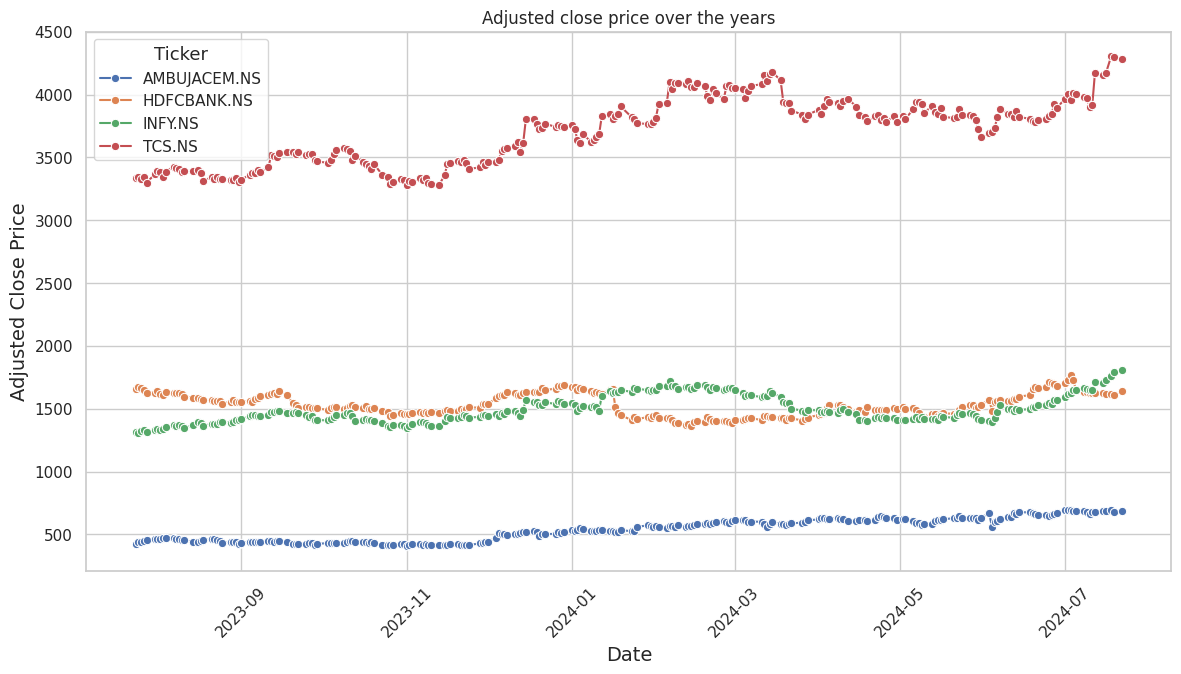

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14,7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted close price over the years')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)
plt.show()




TCS has the highest adjusted close prices, followed by INFY, HDFCBANK and AMBUJHA cement

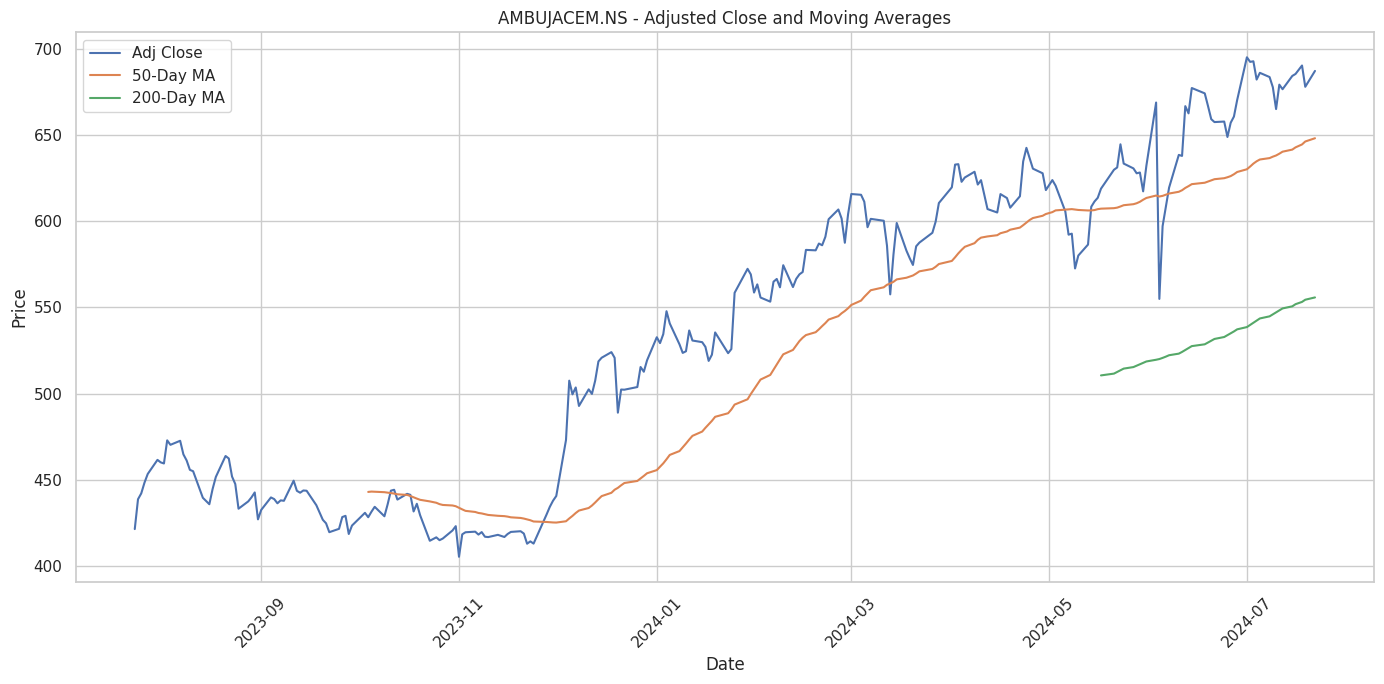

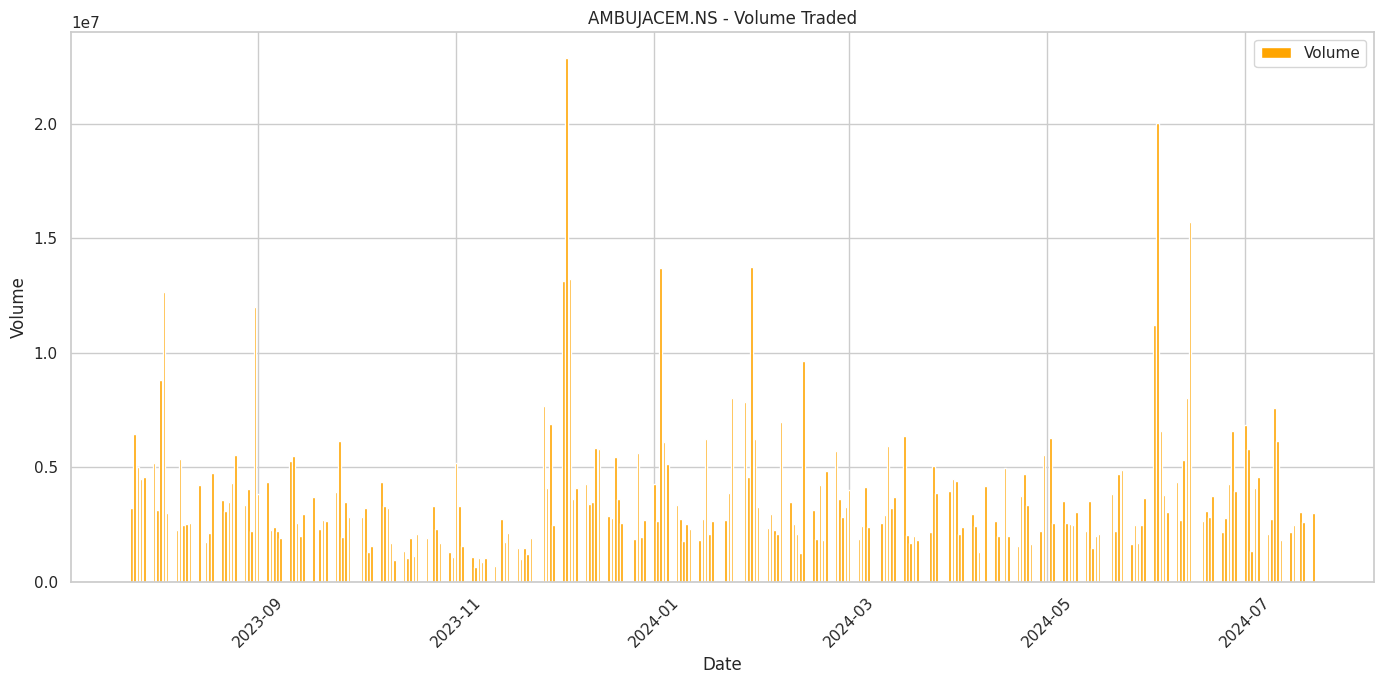

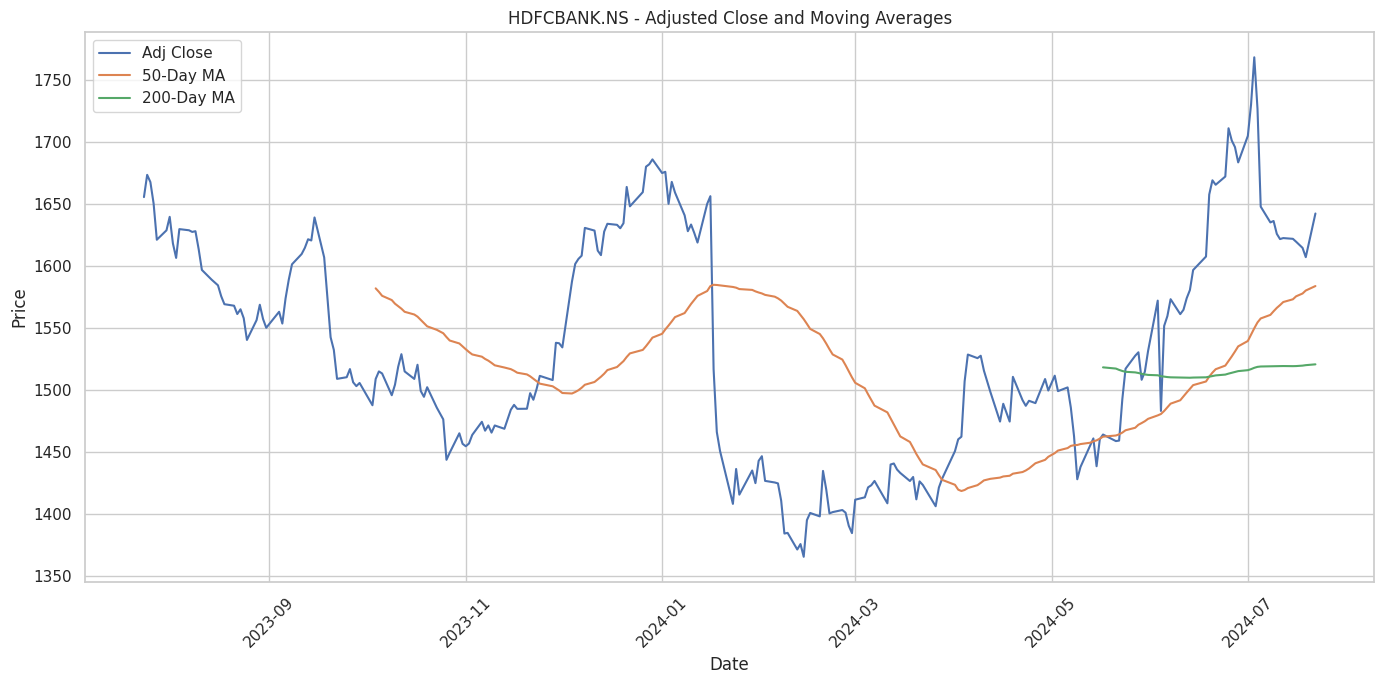

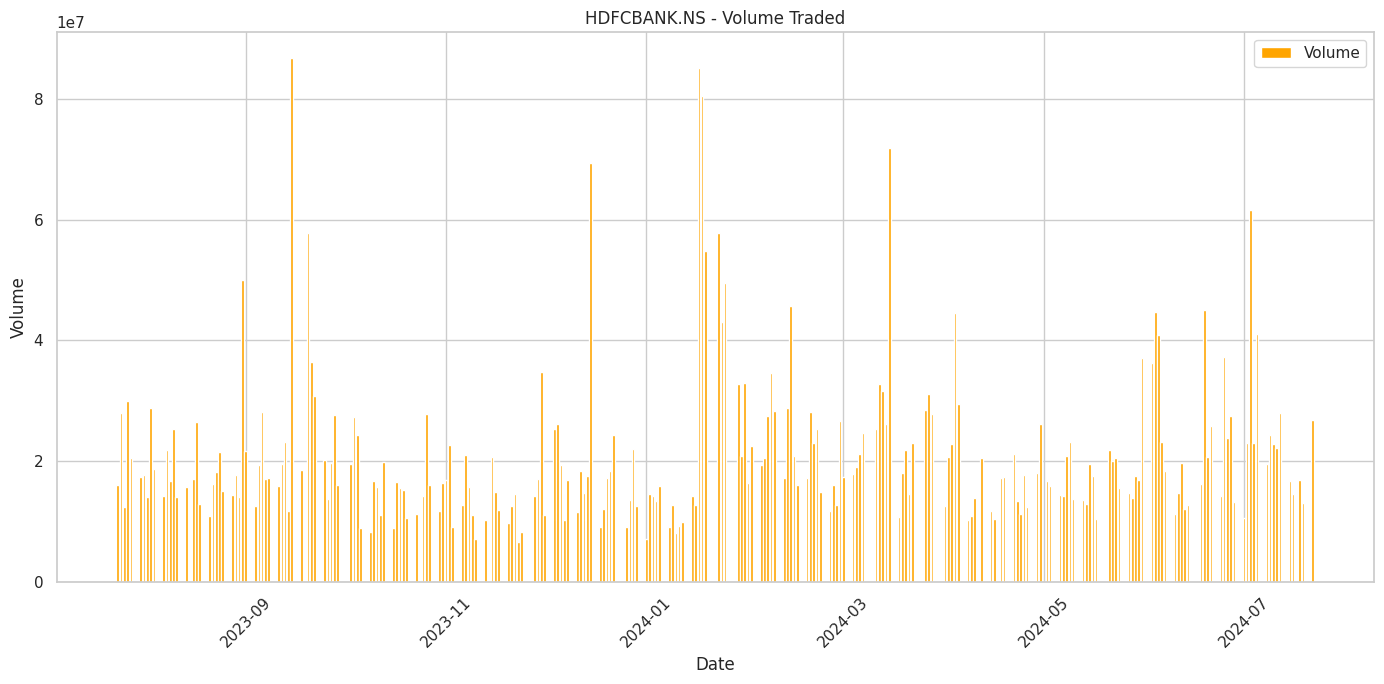

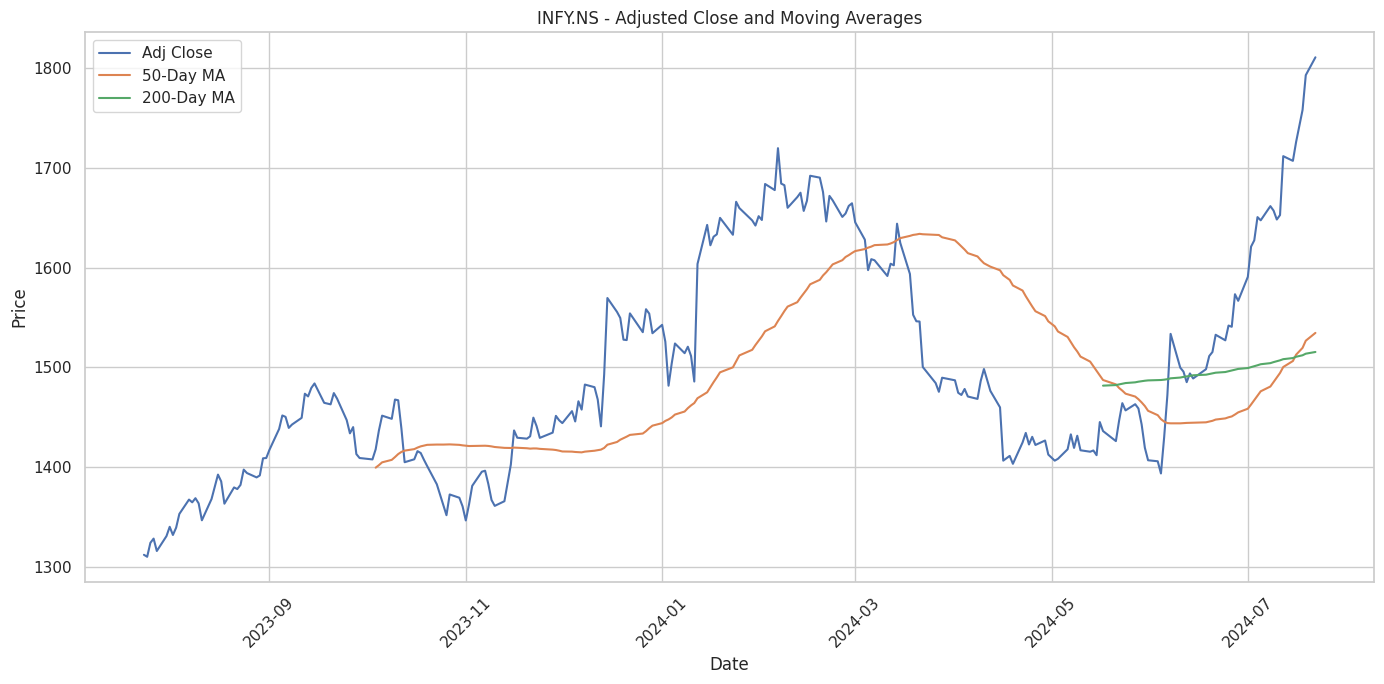

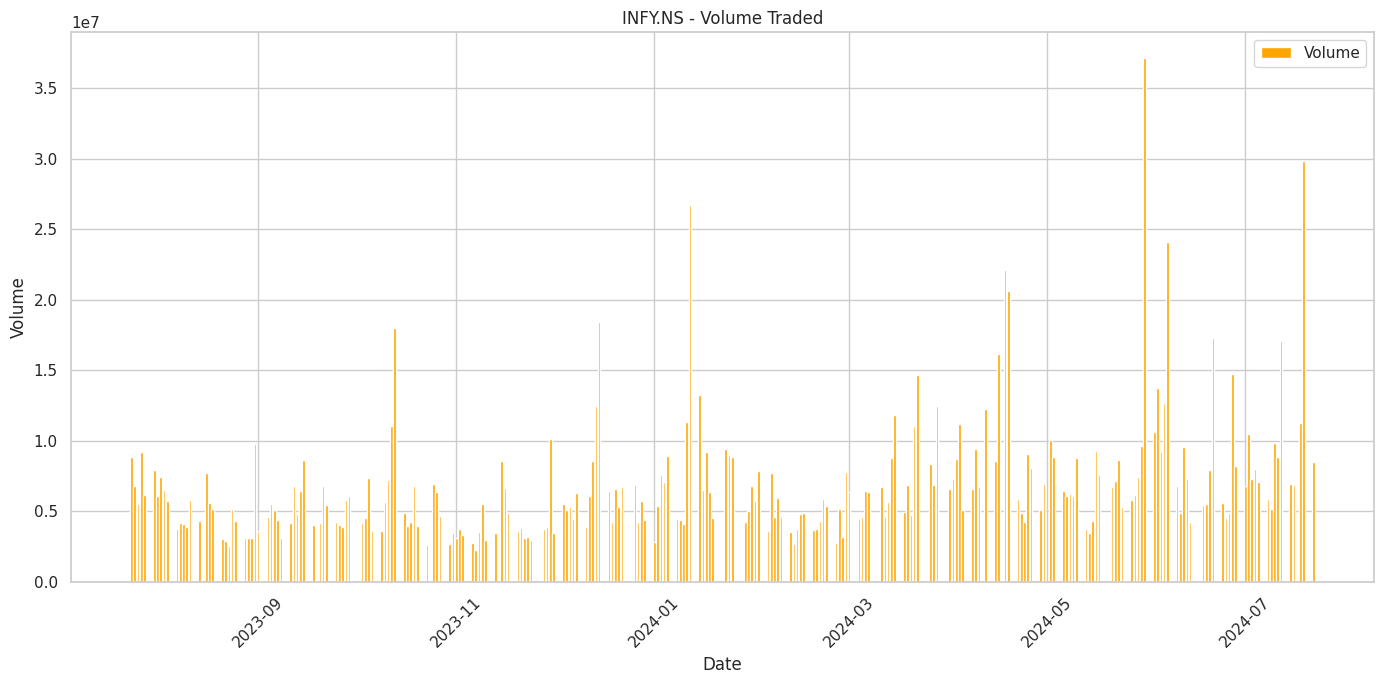

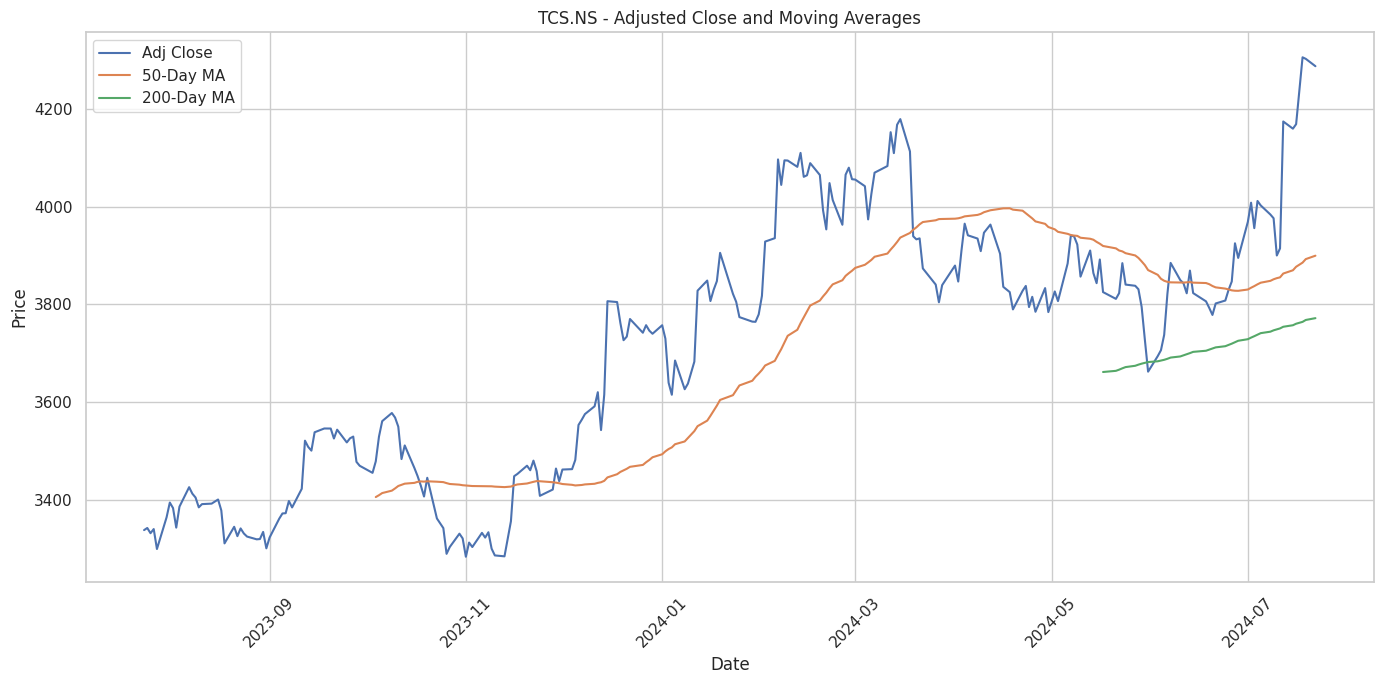

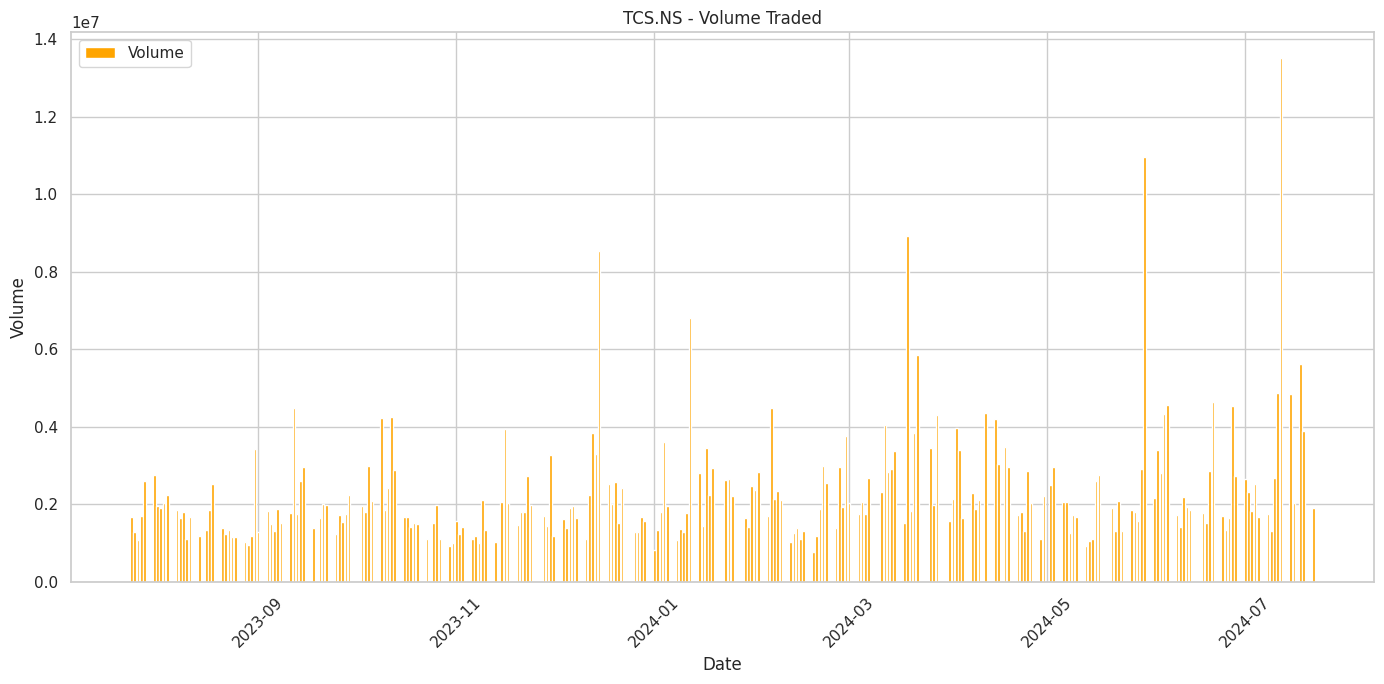

In [6]:
short_window = 50
long_window = 200

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

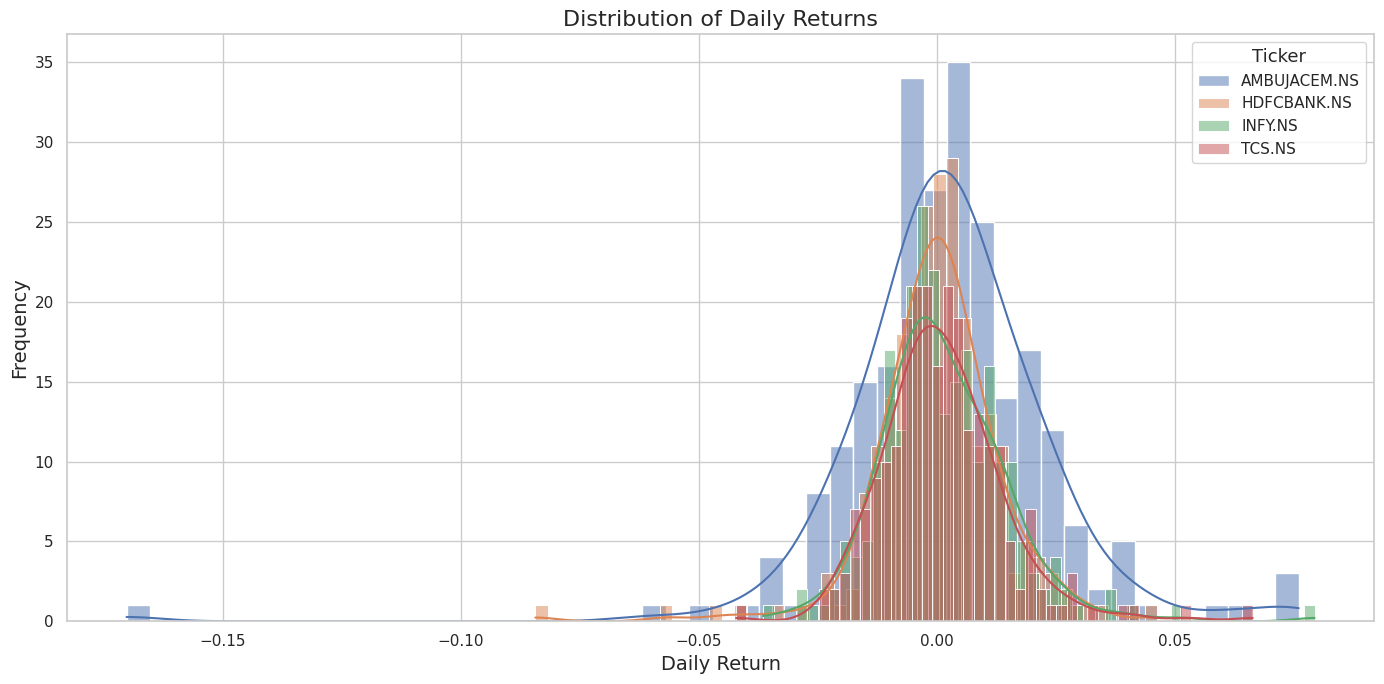

In [8]:
#Distribution of daily returns

stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

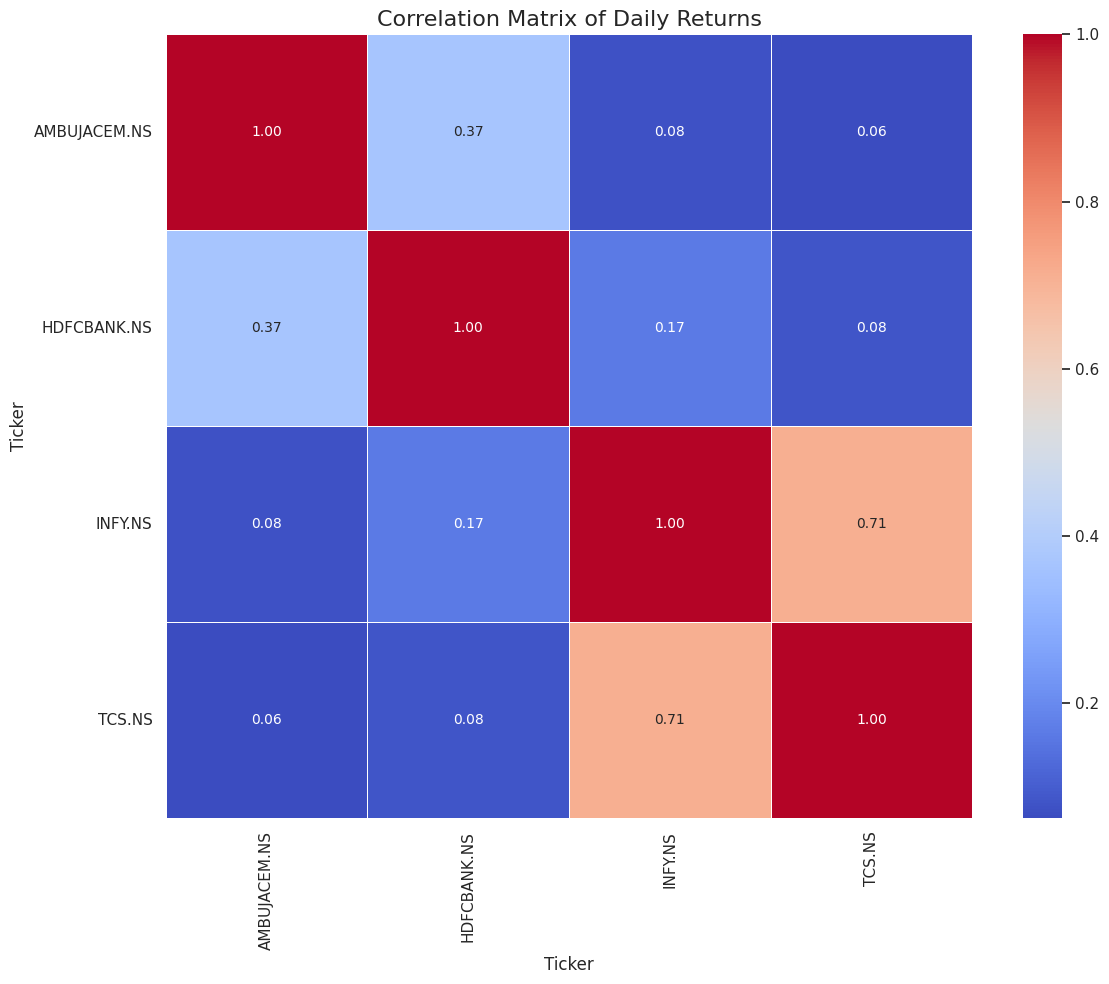

In [12]:
#correlation
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Calculate the expected returns and volatility for each stock.
Generate a series of random portfolios to identify the efficient frontier.
Optimize the portfolio to maximize the Sharpe ratio, which is a measure of risk-adjusted return.

In [13]:
import numpy as np

expected_returns = daily_returns.mean()*252 #annualize the returns
volatility = daily_returns.std()*np.sqrt(252) #annualize the voltality

stock_stats = pd.DataFrame(
    {'Expected Return': expected_returns,
     'volatility': volatility}
)

stock_stats

,Expected Return,volatility
Ticker,,
AMBUJACEM.NS,0.571640,0.349066
HDFCBANK.NS,0.014453,0.212771
INFY.NS,0.357877,0.212275
TCS.NS,0.280804,0.201924


1. Generating a large number of random portfolio weights.

2. Calculate the expected returna and volatility for each portfolio.

3. Plot these portfolios to visualize the efficient frontier.

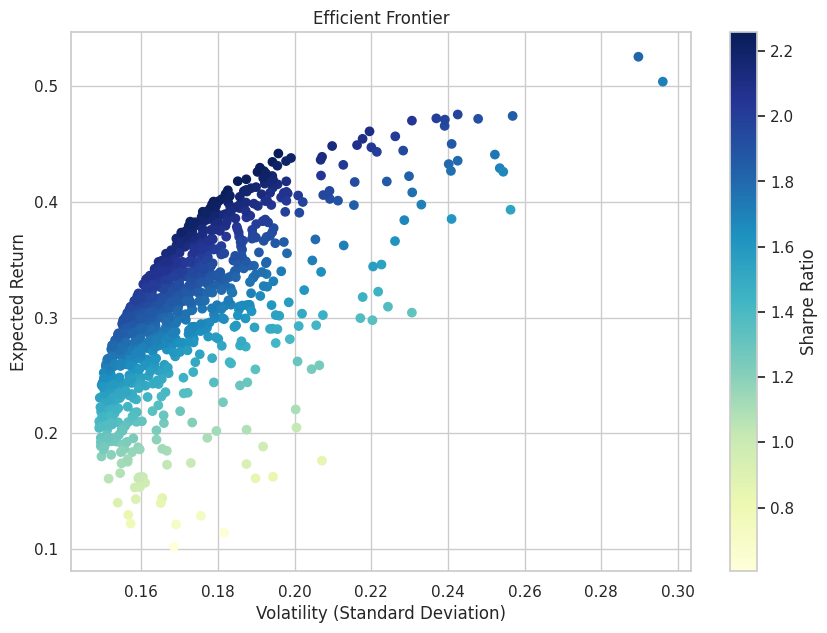

In [14]:
def portfolio_performance(weights, returns, cov_matrix):
  portfolio_return = np.dot(weights, returns)
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
  return portfolio_return, portfolio_volatility

num_portfolios = 1000

results = np.zeros((3, num_portfolios))

cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
  weights = np.random.random(len(daily_returns.columns))
  weights /= np.sum(weights)

  portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

  results[0, i] = portfolio_return
  results[1, i] = portfolio_volatility
  results[2, i] = portfolio_return / portfolio_volatility

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()


In [15]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.4419302735616832, 0.19575687124814944, 2.257546673809852)

In [16]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,AMBUJACEM.NS,0.375989
1,HDFCBANK.NS,0.323239
2,INFY.NS,0.077027
3,TCS.NS,0.223745


So, this is how stock market portfolio optimization works. Stock market portfolio optimization involves analyzing price trends, calculating expected returns and volatilities, and determining the correlations between different stocks to achieve diversification.